In [1]:
# allow for imports from ../src directory

from os import path as os_path
from os import getcwd
from sys import path as sys_path

sys_path.append(os_path.dirname(getcwd())) 

In [36]:
import scipy.optimize as optim
import numpy as np
import pandas as pd
import siunits as unit

from scipy import interpolate
from scipy.integrate import trapezoid
from scipy.constants import epsilon_0, elementary_charge, Boltzmann, Avogadro
from src.helper_functions import read_render_markdown_file, make_simple_plot

### Physical constants

1. the electric constant (vacuum permittivity) $\epsilon_0$. Units:  $\textstyle{\rm s^{4}\cdot A^{2}\cdot kg^{-1}\cdot m^{-3}}$ or $\textstyle{\rm C^2 \cdot N^{−1} \cdot m^{−2}}$ or $\textstyle{\rm C \cdot V^{−1} \cdot m^{−1}}$ 

In [3]:
unit.epsilon_0

ampere²·second⁴·meter⁻³·kilogram⁻¹ (A²·s⁴·m⁻³·kg⁻¹), [kg: -1, s: 4, A: 2, m: -3]

In [4]:
epsilon_0

8.8541878128e-12

2. Elementary charge (charge on electron). Units: $\rm C$

In [5]:
unit.c

coulomb (C), [s: 1, A: 1]

In [6]:
elementary_charge

1.602176634e-19

3. Boltzmann constant. Units: $\rm m^2 \cdot kg \cdot s^{-2} \cdot {K}^{-1}$

In [7]:
Boltzmann

1.380649e-23

4. Avogadro's number. Units: $\rm mol^{-1}$

In [8]:
Avogadro

6.02214076e+23

### Singlet model parameters

See Page 62

Dictionary of model parameters

In [9]:
fluid = "kcl"

In [10]:
parameters = dict({"kcl": dict({"component": ["K", "Cl"], "valence": np.array([
                  1.0, -1.0]), "temperature": 1075.0, "concentration": [19.265, 19.265]})})


In [11]:
for param_name in parameters[fluid].keys():
    locals().__setitem__(param_name, parameters[fluid][param_name])
    print(f"Created variable - {param_name}: {str(parameters[fluid][param_name])}")


n_component = len(component)
n_pair = int((n_component+1) * (n_component) / 2)

Created variable - component: ['K', 'Cl']
Created variable - valence: [ 1. -1.]
Created variable - temperature: 1075.0
Created variable - concentration: [19.265, 19.265]


Numerical discretisation

In [12]:
z_cutoff = 50.0    # from UI
n_point = 2001     # from UI
grid_size = z_cutoff / (n_point - 1) 
z = np.linspace(0.0, z_cutoff, n_point)

$\beta = 1 / k T$. Units: $\rm m^{-2} \cdot kg^{-1} \cdot s^{2}$

In [13]:
beta = 1.0 / (Boltzmann * temperature)

In [31]:
epsilon = 4.0 * np.pi * epsilon_0   # units same as $\epsilon_0$

Model potential KCl

In [14]:
read_render_markdown_file("../docs/equation_4_1.md")
read_render_markdown_file("../docs/equation_4_2.md")
read_render_markdown_file("../docs/equation_4_3.md")

$$ u_{ij}(r) = \frac{q_i q_j}{\varepsilon r} + B_{ij} \exp(-\alpha r) + \frac{C_ij}{r^6} + \frac{D_{ij}}{r^8} $$

$$ B_{ij} = \beta_{ij} \, b \exp[\alpha(\sigma_i + \sigma_j)] $$

$$ \beta_{ij} = 1 + \frac{Z_i}{n_i} + \frac{Z_j}{n_j} $$

In [15]:
n_outer_shell = np.array([8., 8.])

In [16]:
def calc_l_index(i, j):
    return i + j    

In [17]:
def calc_beta_pauling(valence, n_outer_shell):
    beta_pauling = np.zeros(n_pair)
    for i in range(n_component):
        for j in range(i, n_component):
            l = calc_l_index(i, j)
            beta_pauling[l] = 1.0 + valence[i] / n_outer_shell[i] + valence[j] / n_outer_shell[j]
    return beta_pauling

In [18]:
beta_pauling = calc_beta_pauling(valence, n_outer_shell)

In [19]:
beta_pauling

array([1.25, 1.  , 0.75])

In [20]:
alpha = 1.0 / 0.337
b = 0.338e-19
sigma = [1.463, 1.585]

cap_c = np.array([24.3, 48.0, 124.5]) * 1e-19
cap_d = np.array([24.0, 73.0, 250.0]) * 1e-19

In [21]:
def calc_cap_b(beta_pauling, b, alpha, sigma):
    cap_b = np.zeros(n_pair)
    for i in range(n_component):
        for j in range(i, n_component):
            l = calc_l_index(i, j)
            cap_b[l] = beta_pauling[l] * b * np.exp(alpha * (sigma[i] + sigma[j]))
    return cap_b

In [22]:
cap_b = calc_cap_b(beta_pauling, b, alpha, sigma)

In [23]:
beta * cap_b

array([16791.65813278, 19293.2728126 , 20782.10350479])

In [46]:
#TODO: Fix up choice of c(r) / c*(r) and make sure discretisation matches

# Read in some c(r)
def load_cr():
    CR_PATH = "../pyOZ_bulk_fluid/tests/lj/nrcg-cr.dat.orig"
    cr_df = pd.read_csv(CR_PATH, header=None, delim_whitespace=True)
    cr_df.set_index(0, inplace=True)
    r = cr_df.index.to_numpy()
    cr = cr_df.to_numpy()
    return cr, r

In [63]:
cr_in, r_in = load_cr()

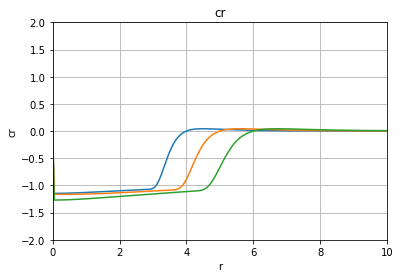

'cr'

In [64]:
make_simple_plot(r_in, cr_in, "r", "cr", "cr", yliml=[-2, 2])

In [75]:

def interpolate_cr(r_in, cr_in):
    cr = np.zeros((n_point, n_pair))
    for l in range(n_pair):
        f = interpolate.interp1d(r_in, cr_in[:, l])
        r = z
        cr[:, l] = f(r)
    return cr, r

In [76]:
cr, r = interpolate_cr(r_in, cr_in)

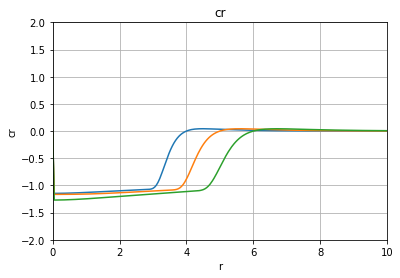

'cr'

In [77]:
make_simple_plot(r, cr, "r", "cr", "cr", yliml=[-2, 2])

In [78]:
# Use same discretisation for r as z [Confirm?]

def calc_u(valence, cap_b, alpha, cap_c, cap_d, r):
    u = np.zeros((n_point, n_pair))
    for i in range(n_component):
        for j in range(i, n_component):
            l = calc_l_index(i, j)
            u[1:, l] = valence[i] * valence[j] / (r[1:] * epsilon)
    return u 


In [79]:
u = calc_u(valence, cap_b, alpha, cap_c, cap_d, r)

In [82]:
u

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.59502072e+11, -3.59502072e+11,  3.59502072e+11],
       [ 1.79751036e+11, -1.79751036e+11,  1.79751036e+11],
       ...,
       [ 1.79930967e+08, -1.79930967e+08,  1.79930967e+08],
       [ 1.79840956e+08, -1.79840956e+08,  1.79840956e+08],
       [ 1.79751036e+08, -1.79751036e+08,  1.79751036e+08]])

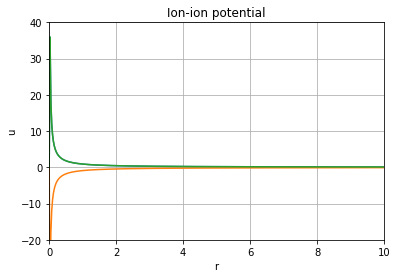

'Ion-ion potential'

In [84]:
make_simple_plot(r, u/1e10, "r", "u", "Ion-ion potential")

In [ ]:
psi_0 = 0     # 0 mV  -- get from UI

rho ($\rho$) is the number density which we calculate from the concentration ($c$):

$\rho = c \, \rm mol \, dm^{-3} \cdot dm^{3} / 1.0 \cdot 10^{27} \cdot A^{3} \cdot N_{A} \, mol^{-1}$. Units: $\rm A^{-3}$


In [ ]:
def calc_rho(concentration):
    return np.array(concentration) / 1.0e27 * Avogadro

In [ ]:
rho = calc_rho(concentration)

In [ ]:
rho   # values seem reasonable (compared with those in thesis)

In [ ]:
def calc_charge(valence):
    return valence * elementary_charge

In [ ]:
charge = calc_charge(valence)

In [ ]:
def calc_kappa(beta, rho, epsilon):
    return np.sqrt(4.0 * np.pi * beta / epsilon * 1e10 *
    sum(np.multiply(charge**2, rho)))


In [ ]:
kappa = calc_kappa(beta, rho, epsilon)

In [ ]:
kappa      # similar to thesis value (6.77) page 62 - maybe revisions to physical constants in past 25 years (e.g. 2019 change for $e$)

### Wall-ion soft-potential

In [ ]:
phiw = np.zeros((n_point, n_component))
hw = np.zeros((n_point, n_component))
tw = np.zeros((n_point, n_component))
int_0_z = np.zeros((n_point, n_component))
int_z_inf = np.zeros((n_point, n_component))

In [ ]:
# same for both ions

def calc_phiw(z, n_component):
    capital_a = 16.274e-19 # joules
    wall_d = 2.97  # inverse Angstrom
    for i in range(n_component):
        phiw[:, i] = np.exp(-wall_d * z) * capital_a * (wall_d * z + 2)
    return phiw


In [ ]:
beta_phiw = beta * calc_phiw(z, n_component)

In [ ]:
make_simple_plot(z, beta_phiw, "z", "$beta phi_{wi}(z)$", "Dimensionless wall-ion potentials")

This dimensionless plot matches well with Figure 4.1(b) of thesis.

### Bulk fluid inputs

Not sure what to do here -- maybe run pyOZ for ionic fluid and try using c_{ij}(r) from this as an approximation?

In [ ]:
read_render_markdown_file("../docs/equation_3_4.md")

In [ ]:
l = 0
for i in range(n_component):
    for j in range(i, n_component):
        l = l+1
        print(f"i: {i}, j: {j}, l: {l}", calc_l_index(i, j))

In [ ]:
# Assume all of the moments of the short-ranged bulk direct correlation functions to be zero initially

f1 = np.zeros((n_point, n_pair))
f2 = np.zeros((n_point, n_pair))
c_short = np.zeros((n_point, n_pair))

In [ ]:
# for now assume c*(r) = c(r)

c_short = cr.to_numpy(dtype=np.float64)

In [ ]:
charge_pair = np.array([1, -1, 1]) * elementary_charge

In [ ]:
read_render_markdown_file("../docs/equation_3_5.md")

In [ ]:
# numpy resources - understanding 1D arrays

# See https://stackoverflow.com/questions/5954603/transposing-a-1d-numpy-array

# https://stackoverflow.com/questions/65248933/best-approach-to-use-numpy-1d-arrays-for-linear-algebra

# https://www.oreilly.com/library/view/python-for-data/9781449323592/ch04.html

# https://phys.libretexts.org/Bookshelves/Mathematical_Physics_and_Pedagogy/Computational_Physics_(Chong)/04%3A_Numerical_Linear_Algebra/4.01%3A_Array_Representations_of_Vectors_Matrices_and_Tensors

In [ ]:
#TODO: Too big?

beta * charge_pair[0] / epsilon / 1e10

In [ ]:
c_short

In [ ]:
# skip r = 0 to avoid divide by 0 error

#for l in range(n_pair):
#    c_short[1:, l] = c_short[1:, l]  + beta * charge_pair[l] * 1e-10 / (epsilon * r[1:])
    

In [ ]:
c_short

In [ ]:
make_simple_plot(r, c_short, "r", "$c_{ij}^*$", "SR direct correlation ion-ion functions", xliml=[0, 20], yliml=[-2, 2])

In [ ]:
def int_z_infty_dr_r_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f1[k, ij] = trapezoid(y=z[:k] * c_short[k, ij], x=z[:k])
    return f1

In [ ]:
def int_z_infty_dr_r2_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f2[k, ij] = trapezoid(y=z[:k] * z[:k] * c_short[k, ij], x=z[:k])
    return f2

In [ ]:
f1 = int_z_infty_dr_r_c_short(c_short, z)

In [ ]:
make_simple_plot(z, f1, "z", "$f_{ij}(z)$", "Moment 1 of c^*(r)", yliml=[-10, 10])

In [ ]:
f2 = int_z_infty_dr_r2_c_short(c_short, z)

In [ ]:
make_simple_plot(z, f2, "z", "$f2_{ij}(z)$", "Moment 2 of c^*(r)", yliml=[-10, 10])

Initial guess for solution $t_{wi}(z)$ - solving $F(t(z)) = 0$

In [ ]:
tw = np.zeros((n_point, n_component))    # initial guess of zero - maybe should be \beta \phi

# tw = beta_phiw_i

In [ ]:
make_simple_plot(z, tw, "z", "$t_{wi}(z)$", "Initial guess for $t_{wi}(z)$")

In [ ]:
def calc_hw(tw, beta_phiw):
    for i in range(n_component):
        hw[:, i] = np.exp(tw[:, i]) * np.exp(-beta_phiw[:, i]) - 1.0
        return hw


In [ ]:
hw = calc_hw(tw, beta_phiw)

In [ ]:
make_simple_plot(z, hw, "z", "$h_{wi}(z)$", "Initial version of $h_{wi}(z)$", yliml=[-1, 2])

In [ ]:
beta_psi =  psi_0 * charge * beta

In [ ]:
read_render_markdown_file("../docs/equation_5_9.md")
read_render_markdown_file("../docs/equation_5_9b.md")

In [ ]:
def calc_tw(tw, beta_psi, beta_phiw, rho, f1, f2, z):
    hw = calc_hw(tw, beta_phiw)

    for i in range(n_component):
        tw[:, i] = -beta_psi[i] 
        for k, _ in enumerate(z):
            int_0_z[k, i] = trapezoid(y=z[:k] * hw[:k, i], x=z[:k])
            int_z_inf[k, i] = trapezoid(y=hw[k:, i], x=z[k:])
            for j in range(n_component):
                l = calc_l_index(i, j)
                tw[k, i] = tw[k, i] + 2.0 * np.pi * rho[j] * (z[k] * f1[k, l] - f2[k, l])
                
            #TODO: NEXT: Complete adding f_ij(z) terms - need to fix sum_{ij} for f functions

            #     2.0 * np.pi * (rho[i] * z[k] * f1[k, i] - f2[k, i]) + \
            #    2.0 * charge[i] * charge[j] / epsilon * (int_z_inf[k, i] + z[k] * int_0_z[k, i])  # + int_0_inf
    return tw


In [ ]:
calc_tw(tw, beta_psi, beta_phiw, rho, f1, f2, z)

In [ ]:
make_simple_plot(z, tw, "z", "$t_{wi}(z)$", "Current $t_{wi}(z)$", yliml=[-2, 2])

### Numerical solver: Newton-GMRES

In [ ]:
# this should equal 0 (as t(z) converges to solution)

def func_opt(tw):
    return tw - calc_tw(tw, beta_psi, beta_phiw, rho, f1, f2, z)

In [ ]:
tolerance = 1e-9

In [ ]:
solution = optim.root(func_opt, tw, method="krylov", jac=None, tol=tolerance, callback=None, options=None)

In [ ]:
tw_solution = solution.x

In [ ]:
tw_solution

In [ ]:
hw_solution = calc_hw(tw_solution, beta_phiw)

In [ ]:
make_simple_plot(z, hw_solution, "z", "ht_{wi}(z)$", "Solution for $h_{wi}(z)$", yliml=[-2, 2])